# New Try
The other methods of displacement finding weren't so nice. So this time let's try by first finding the ROI we need as well as all the ROIs that surround it

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread
from pathlib import Path
import os
from Modules import specificOutline, getFileDir, getOutlines, smoother, splitImg, plotSide # Custom module for readability
import Modules_Displacement # custom module for readability
import Modules
from PIL import Image

# List of Files
# Importing all the files

# If the folder containing the .npy and png (or .tif files) are stored 
npyDir = "MCA_Normal"
basedir = os.path.join(Path.cwd(), npyDir)

files = io.get_image_files(basedir, "")

# Makes the directy to point to the seg files
dir = []
for f in files: 
    dir.append((os.path.join(basedir, f) + "_seg.npy").replace(".tif", ""))
dir = dir

In [2]:

roi_name = [] # a list containing the name of the roi we need

for i in range(len(dir)):  
    dat = np.load(dir[i], allow_pickle=True).item()
    masks = dat['masks'] # Using the masks gives us a larger target to select from than outlines
    filenam = dat['filename']
    width, height = masks.shape
    neededROI = masks[width//2][height//2] # the general area of where our ROI will always be
    # the below code saves the outline in an image file
    if neededROI != 0: 
        roi_name.append([i, neededROI])



# Method
The thought process for this method is that the cell we want will be boreder by other cells. However, the vertexes of those cells will be bordered by 3 cells. The cell we want, and two other cells. 

The "outlines" part of the .npy files contains the outlines for a particular cell. By iterating through this 2D array, we can obtain the coordinates for the border of the cell we are interested in. Now for each of these coordinates, we can create a 3 x 3 sized 2D matrix subarray where the coordinate we input is the center. This will give us the coordinates for the vertexes


In [3]:
num, roi = roi_name[5]

dat = np.load(dir[num], allow_pickle=True).item()
masks = dat['masks']
outlines = dat['outlines']

m = specificOutline(masks, roi)
o = specificOutline(outlines, roi) # the 2D array with the outlines


In [4]:
height, width = o.shape 
points = []

for i in range(height): 
    for j in range(width): 
        if o[i][j] != 0: 
            points.append([j, i])

points = np.array(points)

# this will highlight the outline we want
# x = points[:, 0]
# y = points[:, 1]
# plt.scatter(x, y, marker = ".")
# plt.imshow(o)

# points is now a list which contains the coordinates for each point that matters for our outline

In [5]:

# function to find the vertexes. 
# works by looking at the items surround i, j 
# filters out so only the unique items are found
# if it is bordered by more than 3 unique items, then it is a vertex point

def findVertex(masks, j, i, k = 2):  
    surr =[masks.item((j+k, i-k)),
    masks.item((j+k, i)),
    masks.item((j+k, i+k)),
    masks.item((j, i-k)),
    masks.item((j, i)),
    masks.item((j, i+k)),
    masks.item((j-k, i-k)),
    masks.item((j-k, i)),
    masks.item((j-k, i+k))]

    # the set() function returns the unique values of the array. If the size of the list is more than
    # 2, then we can return j, i. As this means that it is bordered by at least 3 cells
    if len(list(set(surr)))>2: 
        return [j, i]

In [6]:
# first lets find the vertex points for the roi we are interested
# points contains the coordinates for the outline we are interested in

def filterVertex(points, masks, distVal = 5): 
    vertexes = []
    for k in range(len(points)): 
        i, j = points[k]
        vert = findVertex(masks, j, i)
        if vert: 
            vertexes.append(vert)
    # now in the vertexes file, there are some points which are overlapping with others
    # in order to fix this, we can remove the points in the vertex file which are close to
    # each other. 
    vertexes = np.array(vertexes)

    for i in range(len(vertexes)): 
        if len(vertexes[i]) > 1: 
            a, b = vertexes[i]
            for j in range(len(vertexes)): 
                if i != j: 
                    c, d = vertexes[j]
                    dist = np.sqrt((a - c)**2 + (b - d)**2) # displacement formula
                    if dist < distVal: # distval determines the max distance between vertexes
                        vertexes[j] = -1 # setting those values as -1

    # now we filter out the entries with -1, giving us the values we require
    vert2 = []
    for i in range(len(vertexes)): 
        if vertexes[i][0] > 0: 
            vert2.append(vertexes[i])
    return vert2

In [7]:
listVertexes = []
M = []
O = []

for k in range(len(roi_name)): 
    # Get the file number, and the roi of the cell we are interested in
    num, roi = roi_name[k]
    dat = np.load(dir[num], allow_pickle=True).item()
    masks = dat['masks']
    outlines = dat['outlines']

    # Get the masks and the outlines of the cell we are interested in
    # M.append(specificOutline(masks, roi)) # list containing all the masks
    M.append(masks)
    O.append(specificOutline(outlines, roi)) # list containing all the outlines


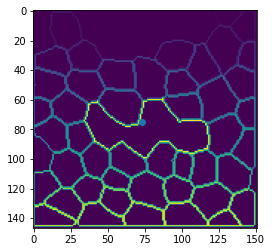

In [8]:
dat = np.load(dir[0], allow_pickle=True).item()
outlines = dat['outlines']
plt.imshow(outlines)
A = M[0]
a, b = A.shape 
A[a//2, b//2]
plt.scatter(a//2, b//2)

In [9]:
pointsList = []

for k in range(len(M)): 
    points = []
    o = O[k]
    height, width = o.shape
    # iterate through the matrix and get the coordinates that make up the outline
    # of the cell we are interested in
    for i in range(height): 
        for j in range(width): 
            if o[i][j] != 0: 
                points.append([j, i])
    # points is now a list which contains the coordinates for each point that matters for our outline
    # store the vertexes for file number k in the array
    pointsList.append(points)

In [10]:
# code ensures each image has the same number of vertexes
# now we get the vertexes for each file, and we get the lengths for each file as well
vertexList = []
lengths = []
for k in range(len(pointsList)): 
    possibleVertex = filterVertex(pointsList[k], M[k])
    if len(possibleVertex) == 11: 
        vertexList.append(possibleVertex)
        lengths.append(len(possibleVertex))
    else: 
        for i in range(10): 
            possibleVertex = filterVertex(pointsList[k], M[k], distVal=i)
            if len(possibleVertex) == 11: 
                vertexList.append(possibleVertex)
                lengths.append(len(possibleVertex))
                break
    
print(lengths)

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]


In [11]:
# Attempt for getting displacement

def dist(f, g): 
    return np.sqrt((f[0] - g[0])**2 + (f[1] - g[1])**2)
displacementList = [[] ]* (len(vertexList) - 1)

for k in range(len(vertexList) - 1): 
    displacement =[]
    v1 = vertexList[k]
    v2 = vertexList[k + 1]
    for j in range(len(v1)): 
        f = v1[j]
        potentialDist = 100
        for h in range(len(v2)): 
                g = v2[h]
                dtest = dist(f, g) # iterate through and find which ones have the small displacement
                if dtest < potentialDist: 
                    potentialDist = dtest
        displacement.append(potentialDist)
    displacementList[k] = displacement

# Problems with this
this method provides much better vertex detetection than the others for sure, but as the lists are created using the append method, there is no way to tell in which direction they are appended. The position of the vertexes may change after ablation, hence the order in which they are appended may change as well. To counteract this, we can take every entry in "vertexList" and compare it with the next entry in vertexList and see which element will have the least displacement. We can then just interchange those points

In [39]:
# for i in range(len(vertexList) - 1):

i = 0 

A= np.asarray(vertexList[i])
B = np.asarray(vertexList[i + 1])
C = B - A
print(C[i])
D = []
for i in range(len(C)): 
    if C[i][0] + C[i][1] != 0: # now we have the points that we need
        D.append([i, C[i]])
small = 0


[ 1 -2]


[[0, array([ 1, -2])],
 [1, array([ 0, 32])],
 [2, array([  1, -32])],
 [4, array([ 0, -1])]]

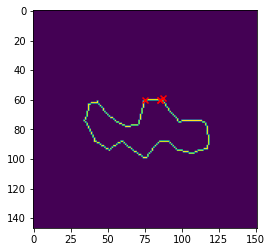

In [13]:


for value in range(4):
    x = np.asarray(vertexList[value])[:, 0]
    y = np.asarray(vertexList[value])[:, 1]

    plt.scatter(y[0], x[0], marker = "x", color = "red")

plt.imshow(O[0])



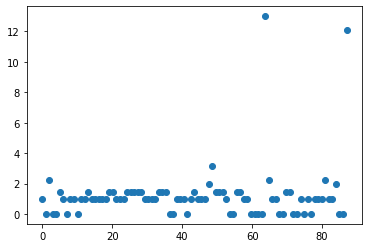

In [14]:
Dtry = displacementList
Dtry = np.asarray(Dtry, dtype='object')
a = Dtry[:, 4]
x = np.linspace(0, len(a), len(a))
plt.scatter(x, a)


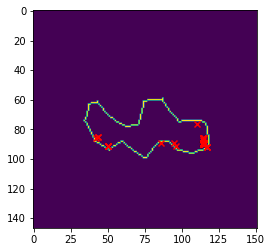

In [15]:

v = 6

for value in range(80):
    x = np.asarray(vertexList[value])[:, 0]
    y = np.asarray(vertexList[value])[:, 1]

    plt.scatter(y[v], x[v], marker = "x", color = "red")

plt.imshow(O[0])

